## Data Augmentation 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import os
from os.path import isfile, join
import pandas as pd
import numpy as np
from skimage.io import imread
from tqdm import tqdm

In [2]:
# First create a data generator
datagen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            zoom_range=0.1,
                            channel_shift_range=10,
                            horizontal_flip=True)

In [3]:
targets = ['baseball', 'cricket', 'football']

In [ ]:
def augment_data(datagen, target: str)->None:
    '''
        This function receives a data generator and target and returns
        a number of copies of the same image with different transformations,
        to increment the number of images for train our model
        
        Parameters:
            datagen: Object generator with the features to transform the image
            target: str
    
        Returns:
            A message of work is done
    '''
    
    # first create a list of the files on the target folder
    target_lst = [f'img/train/{target}/' + f for f in os.listdir(f'img/train/{target}/') if isfile(join(f'img/train/{target}/', f))]
    # path for save the augmentated data
    save_here = f'img/train/{target}/aug'
    try:
        os.stat(save_here) # if folder exits save on it
    except:
        os.mkdir(save_here) # if not, create it and save on it
    for i in tqdm(range(64)):
        # transformation the image
        image = np.expand_dims(imread(target_lst[i]), axis=0) 
        datagen.fit(image)
        # makes the augmetation
        for x, val in zip(datagen.flow(image,                     # image we choose
                                  save_to_dir=save_here,          # the folder on we save the new image 
                                  save_prefix='aug',               
                                  save_format='png'), range(100)): # number of augmented images we want
            pass
    return 'Augmentation Finished'

In [ ]:
for target in targets:
    augment_data(datagen, target)

## Prepare data

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

In [5]:
X = []
Y = []

for file in tqdm(os.listdir('img/train/baseball/aug/')):
    image = imread('img/train/baseball/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(0)

for file in tqdm(os.listdir('img/train/cricket/aug/')):
    image = imread('img/train/cricket/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(1)

for file in tqdm(os.listdir('img/train/football/aug/')):
    image = imread('img/train/football/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(2)

100%|██████████| 4793/4793 [00:15<00:00, 314.66it/s]


In [6]:
X_128 = []
Y_128 = []

for file in tqdm(os.listdir('img/train/baseball/aug/')):
    image = imread('img/train/baseball/aug/'+file)
    smallimage = cv2.resize(image,(128,128))
    X_128.append(smallimage)
    Y_128.append(0)

for file in tqdm(os.listdir('img/train/cricket/aug/')):
    image = imread('img/train/cricket/aug/'+file)
    smallimage = cv2.resize(image,(128,128))
    X_128.append(smallimage)
    Y_128.append(1)

for file in tqdm(os.listdir('img/train/football/aug/')):
    image = imread('img/train/football/aug/'+file)
    smallimage = cv2.resize(image,(128,128))
    X_128.append(smallimage)
    Y_128.append(2)

100%|██████████| 4793/4793 [00:19<00:00, 245.37it/s]


In [7]:
X_32 = []
Y_32 = []

for file in tqdm(os.listdir('img/train/baseball/aug/')):
    image = imread('img/train/baseball/aug/'+file)
    smallimage = cv2.resize(image,(32,32))
    X_32.append(smallimage)
    Y_32.append(0)

for file in tqdm(os.listdir('img/train/cricket/aug/')):
    image = imread('img/train/cricket/aug/'+file)
    smallimage = cv2.resize(image,(32,32))
    X_32.append(smallimage)
    Y_32.append(1)

for file in tqdm(os.listdir('img/train/football/aug/')):
    image = imread('img/train/football/aug/'+file)
    smallimage = cv2.resize(image,(32,32))
    X_32.append(smallimage)
    Y_32.append(2)

100%|██████████| 4793/4793 [00:19<00:00, 249.68it/s]


In [8]:
X,Y = np.array(X), np.array(Y)
X_128,Y_128 = np.array(X_128), np.array(Y_128)
X_32,Y_32 = np.array(X_32), np.array(Y_32)

In [9]:
X = X/255.0 # normalize X
X_128 = X_128/255.0
X_32 = X_32/255.0

In [10]:
from sklearn.utils import shuffle

X,Y = shuffle(X,Y, random_state=42)

X_128,Y_128 = shuffle(X_128,Y_128, random_state=42)

X_32, Y_32 = shuffle(X_32,Y_32, random_state=42)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .2, random_state=42, stratify=Y)

print(X_train.shape); print(X_test.shape)

(11474, 64, 64, 3)
(2869, 64, 64, 3)


In [12]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(np.unique(y_train,return_counts=True),'values of each class')

X_train shape: (11474, 64, 64, 3)
11474 train samples
2869 test samples
(array([0, 1, 2]), array([3814, 3826, 3834], dtype=int64)) values of each class


In [13]:
X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split(X_32,Y_32, test_size = .2, random_state=42, stratify=Y_32)

print(X_train_32.shape); print(X_test_32.shape)

(11474, 32, 32, 3)
(2869, 32, 32, 3)


### Convolutional Network

In [14]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
import numpy as np
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [15]:
Y_train = np_utils.to_categorical(y_train,3)
Y_test = np_utils.to_categorical(y_test,3)

Y_train_32 = np_utils.to_categorical(y_train_32,3)
Y_test_32 = np_utils.to_categorical(y_test_32,3)

### Create metric functions for model evaluation

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
X_train.shape, Y_train.shape

((11474, 64, 64, 3), (11474, 3))

## Create a convolutional Network

Epoch 1/10
90/90 [==============================] - 17s 171ms/step - loss: 0.8218 - accuracy: 0.6043 - f1_m: 0.4907 - recall_m: 0.4219 - precision_m: 0.6997
Epoch 2/10
90/90 [==============================] - 15s 162ms/step - loss: 0.3608 - accuracy: 0.8633 - f1_m: 0.8589 - recall_m: 0.8364 - precision_m: 0.8832
Epoch 3/10
90/90 [==============================] - 15s 163ms/step - loss: 0.1610 - accuracy: 0.9460 - f1_m: 0.9446 - recall_m: 0.9373 - precision_m: 0.9520
Epoch 4/10
90/90 [==============================] - 15s 166ms/step - loss: 0.0813 - accuracy: 0.9745 - f1_m: 0.9748 - recall_m: 0.9714 - precision_m: 0.9782
Epoch 5/10
90/90 [==============================] - 14s 157ms/step - loss: 0.0500 - accuracy: 0.9864 - f1_m: 0.9863 - recall_m: 0.9856 - precision_m: 0.9871
Epoch 6/10
90/90 [==============================] - 15s 163ms/step - loss: 0.0331 - accuracy: 0.9902 - f1_m: 0.9902 - recall_m: 0.9895 - precision_m: 0.9909
Epoch 7/10
90/90 [==============================] - 16s 17

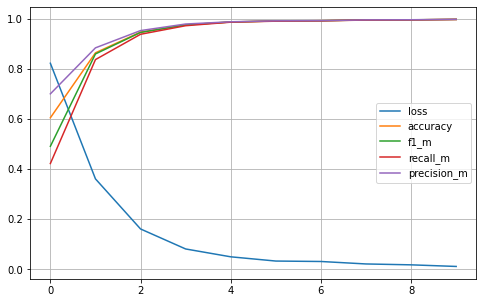

In [18]:
img_rows = 32
img_cols = 32
kernel_size = 4 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model = Sequential()

model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(Convolution2D(64, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", f1_m, recall_m, precision_m])
history_3 = model.fit(
    X_train_32, # Training data
    Y_train_32, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=10, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)
score = model.evaluate(X_test_32, Y_test_32)
print("Test loss", score[0])
print("Test accuracy", score[1])

pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [19]:
test_32 = []

for file in os.listdir('img/test/'):
    image = imread('img/test/'+file)
    smallimage = cv2.resize(image,(32,32))
    test_32.append(smallimage)

test_32 = np.array(test_32)/255.0

1/1 [==============================] - 0s 13ms/step


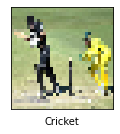

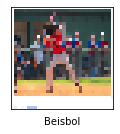

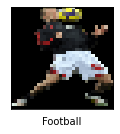

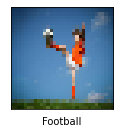

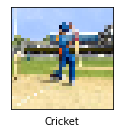

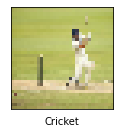

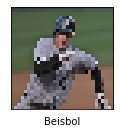

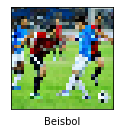

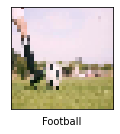

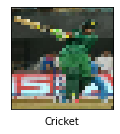

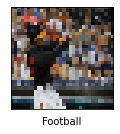

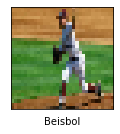

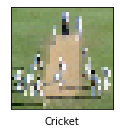

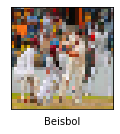

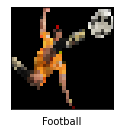

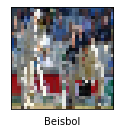

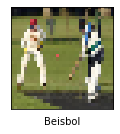

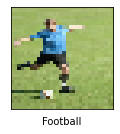

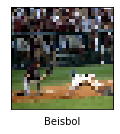

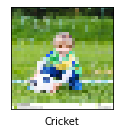

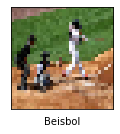

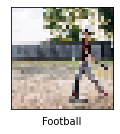

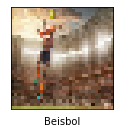

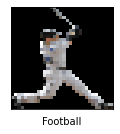

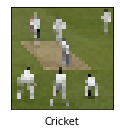

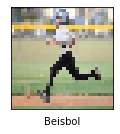

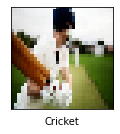

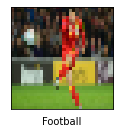

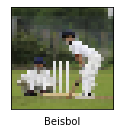

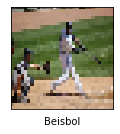

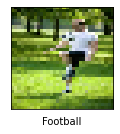

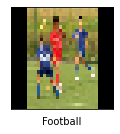

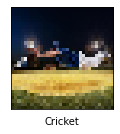

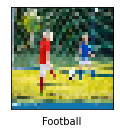

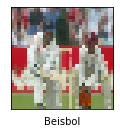

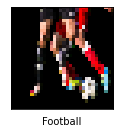

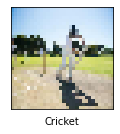

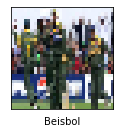

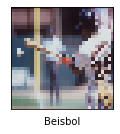

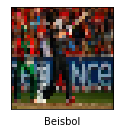

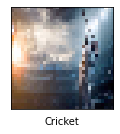

In [20]:
preds_32 = []

for i in range(len(test_32)):
    pred_32 = model.predict(np.expand_dims(test_32[i], axis=0))
    
    if pred_32[0][0]>pred_32[0][1] and pred_32[0][0]>pred_32[0][2]:
        preds_32.append(0)
    elif pred_32[0][1]>pred_32[0][0] and pred_32[0][1]>pred_32[0][2]:
        preds_32.append(1)
    else:
        preds_32.append(2)

for i in range(len(test_32)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if preds_32[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test_32[i])
    elif preds_32[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test_32[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test_32[i])
plt.show()

Epoch 1/11
90/90 [==============================] - 44s 481ms/step - loss: 1.0271 - accuracy: 0.5363 - f1_m: 0.3899 - recall_m: 0.3037 - precision_m: 0.6600
Epoch 2/11
90/90 [==============================] - 41s 451ms/step - loss: 0.5981 - accuracy: 0.7453 - f1_m: 0.7275 - recall_m: 0.6614 - precision_m: 0.8106
Epoch 3/11
90/90 [==============================] - 41s 458ms/step - loss: 0.3626 - accuracy: 0.8620 - f1_m: 0.8574 - recall_m: 0.8271 - precision_m: 0.8905
Epoch 4/11
90/90 [==============================] - 41s 451ms/step - loss: 0.1942 - accuracy: 0.9346 - f1_m: 0.9343 - recall_m: 0.9219 - precision_m: 0.9472
Epoch 5/11
90/90 [==============================] - 41s 456ms/step - loss: 0.0964 - accuracy: 0.9691 - f1_m: 0.9691 - recall_m: 0.9651 - precision_m: 0.9731
Epoch 6/11
90/90 [==============================] - 41s 452ms/step - loss: 0.0663 - accuracy: 0.9796 - f1_m: 0.9793 - recall_m: 0.9770 - precision_m: 0.9816
Epoch 7/11
90/90 [==============================] - 41s 45

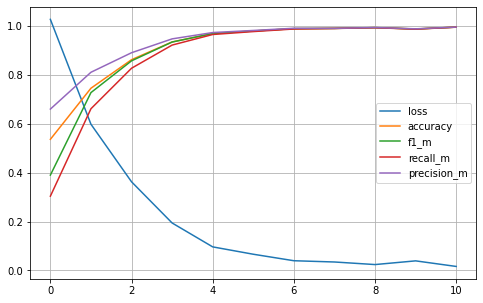

In [21]:
img_rows = 64
img_cols = 64
kernel_size = 4 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model = Sequential()

model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", f1_m, recall_m, precision_m])
history_3 = model.fit(
    X_train, # Training data
    Y_train, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=11, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)
score = model.evaluate(X_test, Y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Prepare data test to predict

In [22]:
test = []

for file in os.listdir('img/test/'):
    image = imread('img/test/'+file)
    smallimage = cv2.resize(image,(64,64))
    test.append(smallimage)

test = np.array(test)/255.0

In [23]:
preds = []
for i in range(len(test)):
    pred = model.predict(np.expand_dims(test[i], axis=0))
    
    if pred[0][0]>pred[0][1] and pred[0][0]>pred[0][2]:
        preds.append(0)
    elif pred[0][1]>pred[0][0] and pred[0][1]>pred[0][2]:
        preds.append(1)
    else:
        preds.append(2)

1/1 [==============================] - 0s 15ms/step


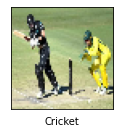

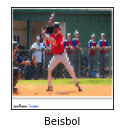

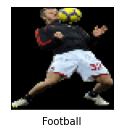

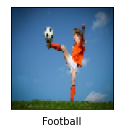

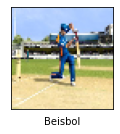

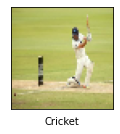

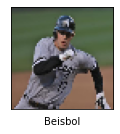

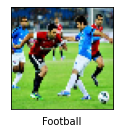

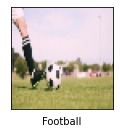

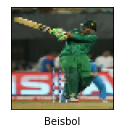

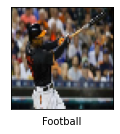

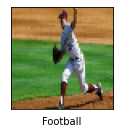

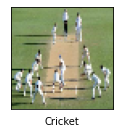

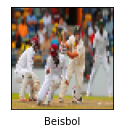

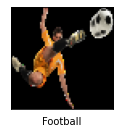

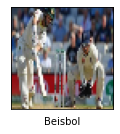

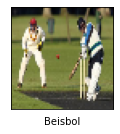

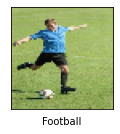

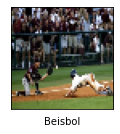

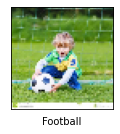

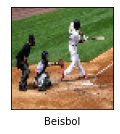

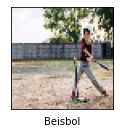

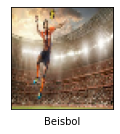

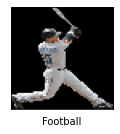

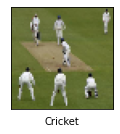

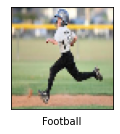

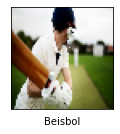

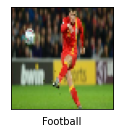

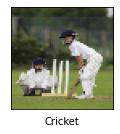

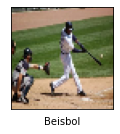

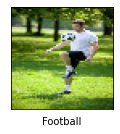

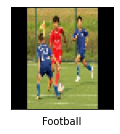

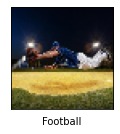

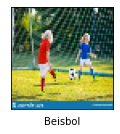

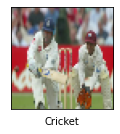

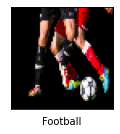

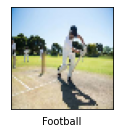

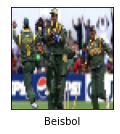

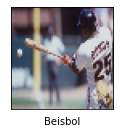

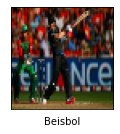

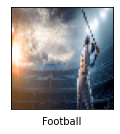

In [24]:
for i in range(len(test)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if preds[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test[i])
    elif preds[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test[i])
plt.show()

## Convolutional network with 128 x 128 pixels images

In [25]:
X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(X_128,Y_128, test_size = .2, random_state=42, stratify=Y_128)

print(X_train_128.shape); print(X_test_128.shape)

(11474, 128, 128, 3)
(2869, 128, 128, 3)


In [26]:
Y_train_128 = np_utils.to_categorical(y_train,3)
Y_test_128 = np_utils.to_categorical(y_test,3)

Epoch 1/4
718/718 [==============================] - 1520s 2s/step - loss: 1.1233 - accuracy: 0.3326 - f1_m: 0.0021 - recall_m: 0.0017 - precision_m: 0.0050
Epoch 2/4
718/718 [==============================] - 1535s 2s/step - loss: 1.0998 - accuracy: 0.3334 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00
Epoch 3/4
718/718 [==============================] - 1548s 2s/step - loss: 1.0995 - accuracy: 0.3324 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00
Epoch 4/4
90/90 [==============================] - 40s 435ms/step - loss: 1.0991 - accuracy: 0.3322 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00
Test loss 1.0990703105926514
Test accuracy 0.3321714997291565


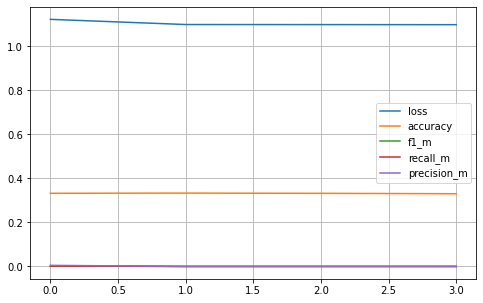

In [27]:
img_rows = 128
img_cols = 128
kernel_size = 4 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model = Sequential()

model.add(Convolution2D(128, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(Convolution2D(64, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(Convolution2D(64, 
                        (kernel_size, kernel_size), 
                        padding='valid', 
                        input_shape=(img_rows, img_cols, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", f1_m, recall_m, precision_m])
history_3 = model.fit(
    X_train_128, # Training data
    Y_train_128, # Labels of training data
    batch_size=16, # Batch size for the optimizer algorithm
    epochs=4, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)
score = model.evaluate(X_test_128, Y_test_128)
print("Test loss", score[0])
print("Test accuracy", score[1])

pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [28]:
test_128 = []

for file in os.listdir('img/test/'):
    image = imread('img/test/'+file)
    smallimage = cv2.resize(image,(128,128))
    test_128.append(smallimage)

test_128 = np.array(test_128)/255.0

In [29]:
preds_128 = []
preds_128_arr = []

for i in range(len(test_128)):
    
    pred_128 = model.predict(np.expand_dims(test_128[i], axis=0))
    preds_128_arr.append(pred_128)
    
    if pred_128[0][0]>pred_128[0][1] and pred_128[0][0]>pred_128[0][2]:
        preds_128.append(0)
    elif pred_128[0][1]>pred_128[0][0] and pred_128[0][1]>pred_128[0][2]:
        preds_128.append(1)
    else:
        preds_128.append(2)


1/1 [==============================] - 0s 53ms/step


## Transfer Learning

In [30]:
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [31]:

base_model = VGG16(input_shape=(64,64,3),
                  include_top = False,
                   weights = 'imagenet'
                  )

In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
## train de last layer of or base model with our data

x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc', f1_m, recall_m, precision_m])

Epoch 1/15
180/180 [==============================] - 51s 282ms/step - loss: 0.2776 - acc: 0.9053 - f1_m: 0.8290 - recall_m: 0.9477 - precision_m: 0.7384
Epoch 2/15
180/180 [==============================] - 53s 296ms/step - loss: 0.0301 - acc: 0.9945 - f1_m: 0.9239 - recall_m: 0.9984 - precision_m: 0.8605
Epoch 3/15
180/180 [==============================] - 52s 291ms/step - loss: 0.0108 - acc: 0.9987 - f1_m: 0.9496 - recall_m: 0.9997 - precision_m: 0.9048
Epoch 4/15
180/180 [==============================] - 55s 304ms/step - loss: 0.0036 - acc: 0.9999 - f1_m: 0.9611 - recall_m: 1.0000 - precision_m: 0.9256
Epoch 5/15
180/180 [==============================] - 57s 319ms/step - loss: 0.0017 - acc: 1.0000 - f1_m: 0.9656 - recall_m: 1.0000 - precision_m: 0.9339
Epoch 6/15
180/180 [==============================] - 52s 287ms/step - loss: 0.0011 - acc: 1.0000 - f1_m: 0.9687 - recall_m: 1.0000 - precision_m: 0.9397
Epoch 7/15
180/180 [==============================] - 52s 288ms/step - loss:

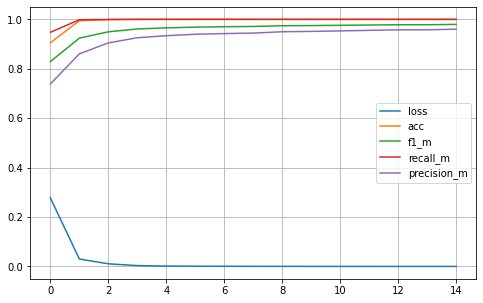

In [35]:
vgghist = model.fit(X_train, Y_train,
                    batch_size=64,
                   epochs = 15)

pd.DataFrame(vgghist.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

### First model transfer learning predictions

In [36]:
tl1_preds = []
tl1_preds_arr = []
for i in range(len(test)):
    tlf1_pred = model.predict(np.expand_dims(test[i], axis=0))
    tl1_preds_arr.append(tlf1_pred)
    #print(pred)
    if tlf1_pred[0][0]>tlf1_pred[0][1] and tlf1_pred[0][0]>tlf1_pred[0][2]:
        tl1_preds.append(0)
    elif tlf1_pred[0][1]>tlf1_pred[0][0] and tlf1_pred[0][1]>tlf1_pred[0][2]:
        tl1_preds.append(1)
    else:
        tl1_preds.append(2)
tl1_preds

1/1 [==============================] - 0s 25ms/step


[2,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 2]

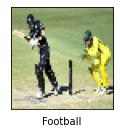

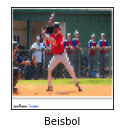

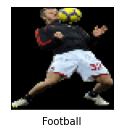

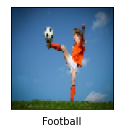

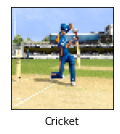

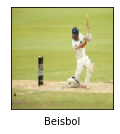

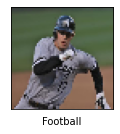

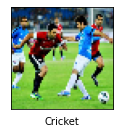

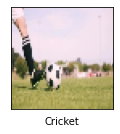

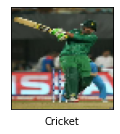

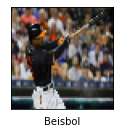

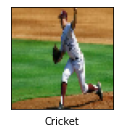

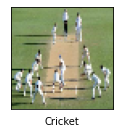

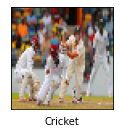

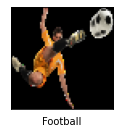

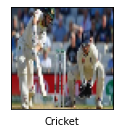

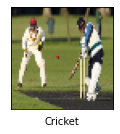

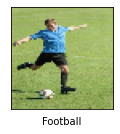

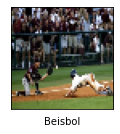

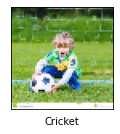

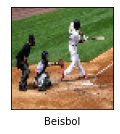

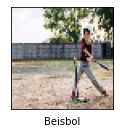

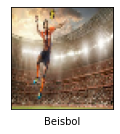

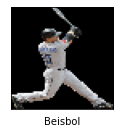

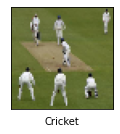

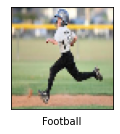

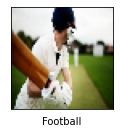

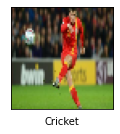

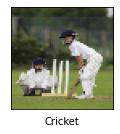

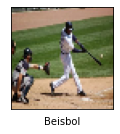

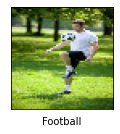

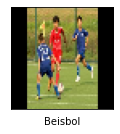

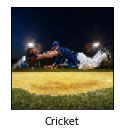

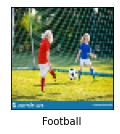

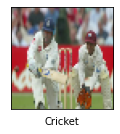

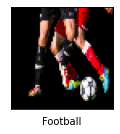

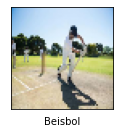

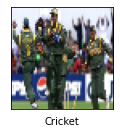

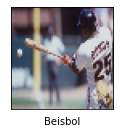

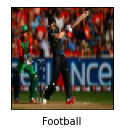

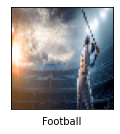

In [37]:
for i in range(len(test)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if tl1_preds[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test[i])
    elif tl1_preds[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test[i])
plt.show()

## Test for samples of 32 x 32


In [46]:
base_model = VGG16(input_shape=(32,32,3),
                  include_top = False,
                   weights = 'imagenet'
                  )

for layer in base_model.layers:
    layer.trainable = False

Epoch 1/10
180/180 [==============================] - 16s 84ms/step - loss: 0.3327 - acc: 0.8611 - f1_m: 0.7775 - recall_m: 0.9268 - precision_m: 0.6708
Epoch 2/10
180/180 [==============================] - 15s 83ms/step - loss: 0.0563 - acc: 0.9819 - f1_m: 0.8860 - recall_m: 0.9963 - precision_m: 0.7984
Epoch 3/10
180/180 [==============================] - 15s 83ms/step - loss: 0.0308 - acc: 0.9899 - f1_m: 0.9174 - recall_m: 0.9976 - precision_m: 0.8503
Epoch 4/10
180/180 [==============================] - 15s 84ms/step - loss: 0.0190 - acc: 0.9931 - f1_m: 0.9314 - recall_m: 0.9990 - precision_m: 0.8732
Epoch 5/10
180/180 [==============================] - 15s 84ms/step - loss: 0.0148 - acc: 0.9949 - f1_m: 0.9275 - recall_m: 0.9993 - precision_m: 0.8663
Epoch 6/10
180/180 [==============================] - 15s 84ms/step - loss: 0.0074 - acc: 0.9977 - f1_m: 0.9545 - recall_m: 0.9998 - precision_m: 0.9137
Epoch 7/10
180/180 [==============================] - 15s 85ms/step - loss: 0.0165

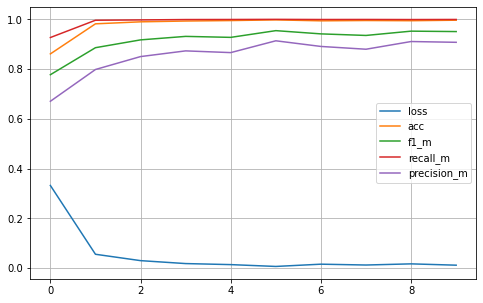

In [47]:
x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(256, activation='relu')(x)

x = layers.Dense(128, activation='relu')(x)

x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc', f1_m, recall_m, precision_m])

vgghist = model.fit(X_train_32, Y_train_32,
                    batch_size=64,
                   epochs = 10)
pd.DataFrame(vgghist.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Make predictions

In [54]:
preds_tl_32 = []
preds_tl_32_arr = []
for i in range(len(test_32)):
    pred_32_tf = model.predict(np.expand_dims(test_32[i], axis=0))
    preds_tl_32_arr.append(pred_32_tf)
    #print(pred)
    if pred_32_tf[0][0]>pred_32_tf[0][1] and pred_32_tf[0][0]>pred_32_tf[0][2]:
        preds_tl_32.append(0)
    elif pred_32_tf[0][1]>pred_32_tf[0][0] and pred_32_tf[0][1]>pred_32_tf[0][2]:
        preds_tl_32.append(1)
    else:
        preds_tl_32.append(2)

1/1 [==============================] - 0s 16ms/step


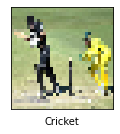

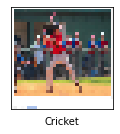

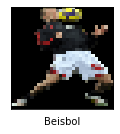

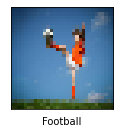

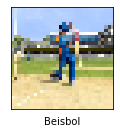

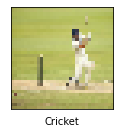

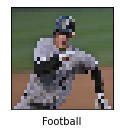

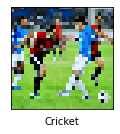

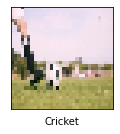

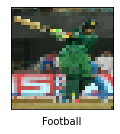

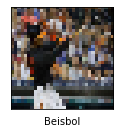

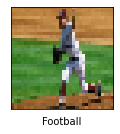

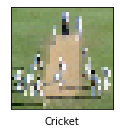

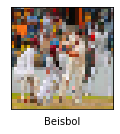

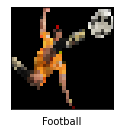

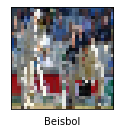

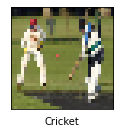

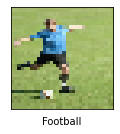

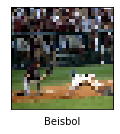

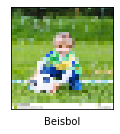

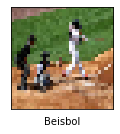

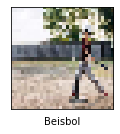

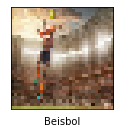

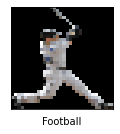

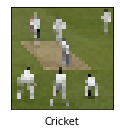

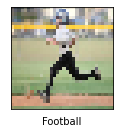

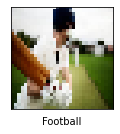

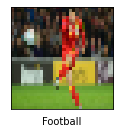

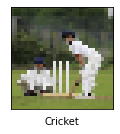

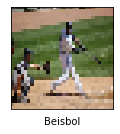

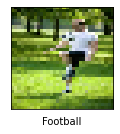

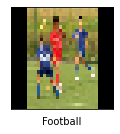

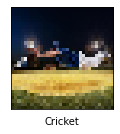

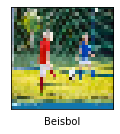

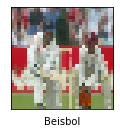

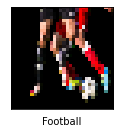

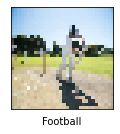

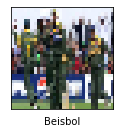

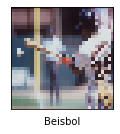

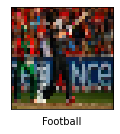

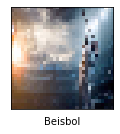

In [50]:
for i in range(len(test_32)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if preds_tl_32[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test_32[i])
    elif preds_tl_32[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test_32[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test_32[i])
plt.show()

## Test for samples of 128 x 128


In [38]:
base_model = VGG16(input_shape=(128,128,3),
                  include_top = False,
                   weights = 'imagenet'
                  )

for layer in base_model.layers:
    layer.trainable = False

Epoch 1/10
180/180 [==============================] - 210s 1s/step - loss: 0.2452 - acc: 0.9042 - f1_m: 0.8381 - recall_m: 0.9375 - precision_m: 0.7605
Epoch 2/10
180/180 [==============================] - 206s 1s/step - loss: 0.0095 - acc: 0.9971 - f1_m: 0.9444 - recall_m: 0.9997 - precision_m: 0.8958
Epoch 3/10
180/180 [==============================] - 206s 1s/step - loss: 0.0175 - acc: 0.9936 - f1_m: 0.9467 - recall_m: 0.9991 - precision_m: 0.9006
Epoch 4/10
180/180 [==============================] - 206s 1s/step - loss: 0.0026 - acc: 0.9994 - f1_m: 0.9632 - recall_m: 0.9999 - precision_m: 0.9297
Epoch 5/10
180/180 [==============================] - 205s 1s/step - loss: 0.0127 - acc: 0.9957 - f1_m: 0.9625 - recall_m: 0.9992 - precision_m: 0.9298
Epoch 6/10
180/180 [==============================] - 206s 1s/step - loss: 0.0030 - acc: 0.9990 - f1_m: 0.9819 - recall_m: 0.9998 - precision_m: 0.9650
Epoch 7/10
180/180 [==============================] - 206s 1s/step - loss: 0.0108 - acc:

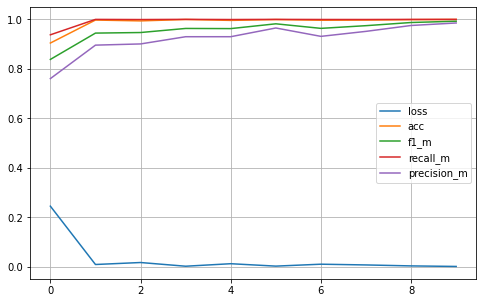

In [39]:
x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(256, activation='relu')(x)

x = layers.Dense(128, activation='relu')(x)

x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc', f1_m, recall_m, precision_m])

vgghist = model.fit(X_train_128, Y_train_128,
                    batch_size=64,
                   epochs = 10)
pd.DataFrame(vgghist.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Make predictions

In [40]:
preds_tl_128 = []
preds_tl_128_arr = []
for i in range(len(test_128)):
    pred_128_tf = model.predict(np.expand_dims(test_128[i], axis=0))
    preds_tl_128_arr.append(pred_128_tf)
    #print(pred)
    if pred_128_tf[0][0]>pred_128_tf[0][1] and pred_128_tf[0][0]>pred_128_tf[0][2]:
        preds_tl_128.append(0)
    elif pred_128_tf[0][1]>pred_128_tf[0][0] and pred_128_tf[0][1]>pred_128_tf[0][2]:
        preds_tl_128.append(1)
    else:
        preds_tl_128.append(2)

1/1 [==============================] - 0s 42ms/step


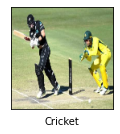

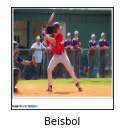

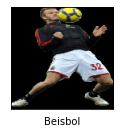

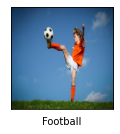

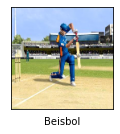

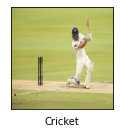

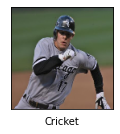

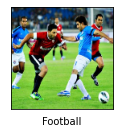

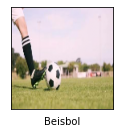

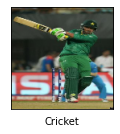

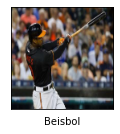

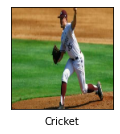

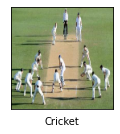

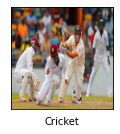

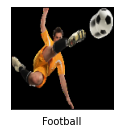

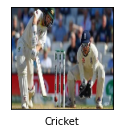

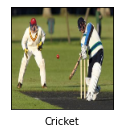

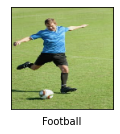

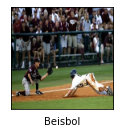

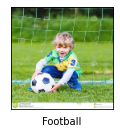

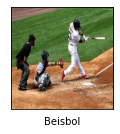

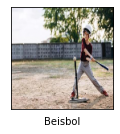

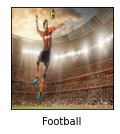

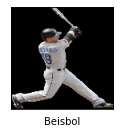

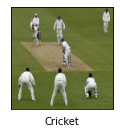

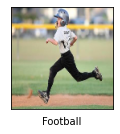

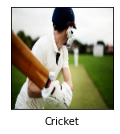

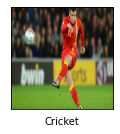

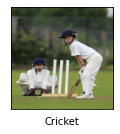

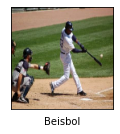

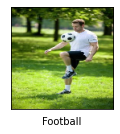

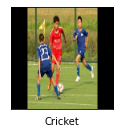

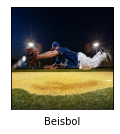

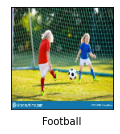

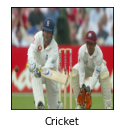

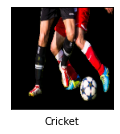

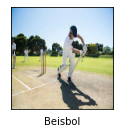

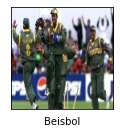

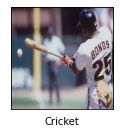

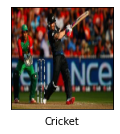

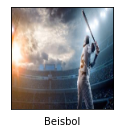

In [41]:

for i in range(len(test_128)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if preds_tl_128[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test_128[i])
    elif preds_tl_128[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test_128[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test_128[i])
plt.show()

In [42]:
#pd.DataFrame(preds_tl_128, columns = ['predictions']).to_csv('predictions/predictions_tfl_model_128_x_128.csv', index=False)

In [43]:
true = [1,0,2,2,1,1,0,2,2,1,0,0,1,1,2,1,1,2,0,2,0,0,2,0,1,0,1,2,1,0,2,2,0,2,1,2,1,1,0,1,0]

In [56]:
preds_conv_32 = 0
pred_tl_32 = 0
preds_conv = 0
preds_conv_128 = 0
pred_res = 0
pred_128_res = 0
for i in range(len(preds_tl_128)):
    if preds_32[i] == true[i]:
        preds_conv_32 += 1
    if preds_tl_32[i] == true[i]:
        pred_tl_32 += 1
    if preds[i] == true[i]:
        preds_conv += 1
    if preds_128[i] == true[i]:
        preds_conv_128 += 1
    if tl1_preds[i] == true[i]:
        pred_res += 1
    if preds_tl_128[i] == true[i]:
        pred_128_res += 1

print('Preds convolutional network 32 x 32: ', preds_conv_32, '\nPreds convolutional network 32 x 32: ', pred_tl_32,
      '\nPreds convolutional network: ', preds_conv,'\nPreds for conv 128x128: ', preds_conv_128,
      '\nPreds for tfl1 64x64: ', pred_res, '\nPreds for tfl2 128x128: ', pred_128_res
     )

Preds convolutional network 32 x 32:  26 
Preds convolutional network 32 x 32:  20 
Preds convolutional network:  24 
Preds for conv 128x128:  13 
Preds for tfl1 64x64:  25 
Preds for tfl2 128x128:  29


In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
#confusion matrix for tf 128 x 128
confusion_matrix(true, preds_tl_128)

array([[ 9,  3,  1],
       [ 3, 12,  0],
       [ 2,  3,  8]], dtype=int64)

In [59]:
confusion_matrix(true, tl1_preds)

array([[ 8,  2,  3],
       [ 2, 10,  3],
       [ 2,  4,  7]], dtype=int64)

In [60]:
confusion_matrix(true, preds_128)

array([[13,  0,  0],
       [15,  0,  0],
       [13,  0,  0]], dtype=int64)

In [61]:
confusion_matrix(true, preds)

array([[ 7,  0,  6],
       [ 8,  6,  1],
       [ 2,  0, 11]], dtype=int64)